# Decision Tree

decision tree是一种分类和回归算法，本质上是if-then的集合，也可以认为是在特征空间与类空间上的条件概率分布。
> 以分类问题为例，训练tree时需要输入data和label，输出预测label。

decision tree的一个重要特点是**互斥且完备**，每个样本只能被一条路径覆盖。

算法主要分为3步：
- 特征选择
- 生成决策树
- 剪枝（泛化降低过拟合）


In [1]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

数据集是mnist图片数据集，label_num=10

In [9]:
#导入数据集
df = pd.read_csv('example_data.csv', dtype={'windy':'str'})

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)
df

,humility,outlook,play,temp,windy
0,high,sunny,no,hot,false
1,high,sunny,no,hot,true
2,high,overcast,yes,hot,false
3,high,rainy,yes,mild,false
4,normal,rainy,yes,cool,false
5,normal,rainy,no,cool,true
6,normal,overcast,yes,cool,true
7,high,sunny,no,mild,false
8,normal,sunny,yes,cool,false
9,normal,rainy,yes,mild,false


# 1. 特征选择
---

> 选取对训练数据**具有分类能力**的特征。

如果一个特征的分类结果与随机分类的结果没什么差别，那么这个特征就没什么分类能力，我们就可以不使用这些特征进行分类。

对于特征选择的准则可以用Information gain（信息增益）。它是通过entropy（熵）来计算的。

## 1.1 信息增益（Information gain）

### 1.1.1 熵与条件熵
#### 熵
> 信息论中，熵entropy是用来描述随机变量不确定性大小的度量，熵越大，不确定性就越大。
- 不确定性就是随机性，熵大说明这个信息没什么价值，因为不确定性太多。

熵的公式：对于随机一个离散随机变量$X$，他的熵是
$$H(X) = -\sum^{n}_{i=1}p_i\log p_i$$

#### 条件熵

> 条件熵是已知随机变量$X$的条件下，随机变量$Y$的不确定性。

公式：$$H(Y|X)=\sum^{n}_{i=1}p_i H(Y|X=x_i)$$

- 其中$i$表示特征$A$不同的取值
- 可以看出条件熵的公式很像$H(Y|X)$的期望

### 1.1.2 信息增益

> 信息增益表示得知特征X的信息而使得Y的信息的不确定性减少程度。简单来说就是，知道了X的信息对认识Y是否更有帮助。
- 由此可见，信息增益越大，这个特征X就越有用。

公式：特征A对训练集D的信息增益为D的经验熵H(D)与特征A给定条件下的经验条件特征熵之差$$g(D,A) = H(D)-H(D|A)$$
- 经验熵empirical entropy是指公式中的概率由极大似然估计得到的。
    - 在决策树中MLE $p(x_i) = \frac{C_i}{D}$，即该特征的样本点在数据集中出现的次数
- 在决策树中，**H(D)是整个数据集的不确定性，H(D|A)是知道了A后数据集D的不确定性**，那这个差越大说明特征A对不确定性的降低越多，就越有用。


#### 信息增益算法
根据信息增益准则选特征的方法就是计算每个特征$A_i$的$g(D,A_i)$，选最大的那个特征。
- input：训练数据集D与特征A
- output：特征A对训练数据集D的$g(D,A)$
1. 计算$H(D)$
    $$H(D) =  -\sum_{k=1}^K\frac{|C_k|}{|D|}\log_2\frac{|C_k|}{|D|}$$
2. 计算每个特征$A_i$的$H(D|A_i)$
    $$H(D|A) = \sum_{i=1}^n\frac{|D_i|}{|D|}H(D_i) = -\sum_{i=1}^n\frac{|D_i|}{|D|}\sum_{k=1}^K\frac{|D_{ik}|}{|D_i|}\log_2\frac{|D_{ik}|}{|D_i|}$$
3. 计算每个$g(D,A_i)$
    $$g(D,A) = H(D)-H(D|A)$$

### 1.1.3 信息增益比（Information Gain ratio）
> 信息增益可能存在偏向**特征选择较多的特征**的问题，比如，如果一个特征的每个可能值都会对应一个唯一的数据点，那这个特征可以完美的划分数据，因此他的IG会是最大的。

信息增益比可以对这一问题进行校正：

$$g_R(D,A) = \frac{g(D,A)}{H_A(D)}$$
其中分子是针对特征A的熵。原本的是针对D的分类的熵

In [5]:
# H(D), entropy实现
def entropy(labels:np.ndarray):
    '''
    计算熵: H(D)
    train_label: 数据集标签1D array,
    '''
    _, counts = np.unique(labels, return_counts=True)
    prob_array = counts/counts.sum()
    return -np.sum(prob_array*np.log2(prob_array))

# H(D|A_i)，条件熵实现
def cond_entropy(train_data, labels):
    '''
    计算条件熵: H(D|A),这里的A是某一个特征
    train_data: 某个特征列的数据集 1D，不是整个数据集
    labels: 标签array 1D
    '''
    labels_len = len(labels)
    unique_features = np.unique(train_data) # 唯一的特征
    ## 1. 用for循环计算该特征下每个特征的 p_i*H(D_i)
    cond_entropy = 0
    for feature in unique_features:
        subset = labels[train_data == feature] #取数据集中特征为该值的标签
        cond_entropy += (len(subset)/labels_len * entropy(subset))
    
    return cond_entropy 


# g(D,A)实现
def calc_IG(feature_col, feature):
    '''
    计算信息增益: G(D,A)
    '''
    return entropy(feature) - cond_entropy(feature_col, feature)
    
# g_R(D,A)实现
def calc_IGR(feature_col, feature):
    '''
    计算信息增益比: G_R(D,A)
    '''
    return calc_IG(feature_col,feature)/entropy(feature_col)

In [35]:
D = np.array([
    [1, 1, 'Yes'],
    [1, 0, 'Yes'],
    [0, 1, 'No'],
    [0, 0, 'No'],
    [1, 0, 'No']
])
print(f'数据集D的熵{entropy(D[:,2])}')
print(f'第一列特征的条件熵{cond_entropy(D[:,0],D[:,2])}')
print(f'第一列的IG: {calc_IG(D[:,0],D[:,2])}')
print(f'第一列的IGR: {calc_IGR(D[:,0],D[:,2])}')

数据集D的熵0.9709505944546686
第一列特征的条件熵0.5509775004326937
第一列的IG: 0.4199730940219749
第一列的IGR: 0.4325380677663126


# 2. 决策树生成
---

决策树生成有多种变形，主要区别在于分类结点的特征选取标准。比较经典的生成算法有：
- ID3
- C4.5
- CART

## 2.1 ID3算法
> 以Information Gain为准则选取特征，递归的构建决策树。

具体步骤：
input：数据集D，特征集A，阈值 $\epsilon$
output: 决策树T
1. if D中的所有实例都属于同一类 $C_k$ -> T为单结点🌲，并将$C_k$作为该node的类标记，返回T
2. if $A = \emptyset$ -> T为单结点tree,数据集中最大的类$C_k$作为该node的类标记，返回T
3. else -> 计算A中各特征对D的**Information Gain**，记录最大的特征$A_g$
4. if $A_g < \epsilon$ -> T为单结点树，将D中实例最大的类最为类标记，返回T
5. else -> 对 $A_g$的每个值 $a_i$依次将D分割为若干非空子集D_i,将D_i中最大的类作为类标记，构建子节点，得到T并返回
6. 对每个子节点，以D_i为训练集，A-{A_g}为特征及，递归调用1-5

In [18]:
def split_dataframe(data, col):
    unique_values = data[col].unique()
    result_dict = {elem: pd.DataFrame for elem in unique_values}
    for key in result_dict.keys():
        result_dict[key] = data[:][data[col] == key]
    return result_dict


def choose_best_col(df, label):
    H_D = entropy(df[label].tolist())
    cols = [col for col in df.columns if col not in [label]]
    max_value, best_col = -999, None
    max_splited = None
    for col in cols:
        splited_set = split_dataframe(df, col)
        H_DA = 0
        for subset_col, subset in splited_set.items():
            H_Di = entropy(subset[label].tolist())
            H_DA += len(subset)/len(df) * H_Di
        IG = H_D - H_DA

        if IG > max_value:
            max_value, best_col = IG, col
            max_splited = splited_set
    return max_value, best_col, max_splited

choose_best_col(df, 'play')

(0.24674981977443933,
 'outlook',
 {'sunny':    humility outlook play  temp  windy
  0      high   sunny   no   hot  false
  1      high   sunny   no   hot   true
  7      high   sunny   no  mild  false
  8    normal   sunny  yes  cool  false
  10   normal   sunny  yes  mild   true,
  'overcast':    humility   outlook play  temp  windy
  2      high  overcast  yes   hot  false
  6    normal  overcast  yes  cool   true
  11     high  overcast  yes  mild   true
  12   normal  overcast  yes   hot  false,
  'rainy':    humility outlook play  temp  windy
  3      high   rainy  yes  mild  false
  4    normal   rainy  yes  cool  false
  5    normal   rainy   no  cool   true
  9    normal   rainy  yes  mild  false
  13     high   rainy   no  mild   true})

In [28]:
class Node:
    ''' 
    ID3的node
    '''
    def __init__(self, name):
        self.name = name        # 结点名
        self.connections = {}   # 结点的child
    
    def connect(self, label, node):
        ''' 
        给当前结点增加child node
        '''
        self.connections[label] = node

class ID3Tree:
    ''' 
    生成一个ID3的决策树
    '''

    def __init__(self, data, label):
        self.columns = data.columns # 返回pd的col name
        self.data = data
        self.label = label
        self.root = Node('Root')
    
    def print_tree(self, node, tabs):
        ''' 
        打印tree的结构
        '''
        print(tabs + node.name)
        for connection, child_node in node.connections.items():
            print(tabs + '\t' + '(' + connection + ')')
            self.print_tree(child_node, tabs + '\t\t')

    def construct(self, parent_node, parent_connection_label, input_data, columns):
        max_value, best_col, max_splited = choose_best_col(input_data[columns], self.label)
        if not best_col:
            node = Node(input_data[self.label].iloc[0])
            parent_node.connect(parent_connection_label, node)
            return 
        node = Node(best_col)
        parent_node.connect(parent_connection_label, node)
        new_columns = [col for col in columns if col!=best_col]
        for splited_value, splited_data in max_splited.items():
            self.construct(node, splited_value, splited_data, new_columns)

    def construct_tree(self):
        self.construct(self.root, "", self.data, self.columns)

In [29]:
tree1 = ID3Tree(df,'play')
tree1.construct_tree()
tree1.print_tree(tree1.root, "")

Root
	()
		outlook
			(sunny)
				humility
					(high)
						temp
							(hot)
								windy
									(false)
										no
									(true)
										no
							(mild)
								windy
									(false)
										no
					(normal)
						temp
							(cool)
								windy
									(false)
										yes
							(mild)
								windy
									(true)
										yes
			(overcast)
				humility
					(high)
						temp
							(hot)
								windy
									(false)
										yes
							(mild)
								windy
									(true)
										yes
					(normal)
						temp
							(cool)
								windy
									(true)
										yes
							(hot)
								windy
									(false)
										yes
			(rainy)
				windy
					(false)
						humility
							(high)
								temp
									(mild)
										yes
							(normal)
								temp
									(cool)
										yes
									(mild)
										yes
					(true)
						humility
							(normal)
								temp
									(cool)
										no
							(high)
								temp
									(mild)
										no


In [2]:
from sklearn import tree
from sklearn.datasets import load_iris
iris = load_iris()
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf = clf.fit(iris.data, iris.target)

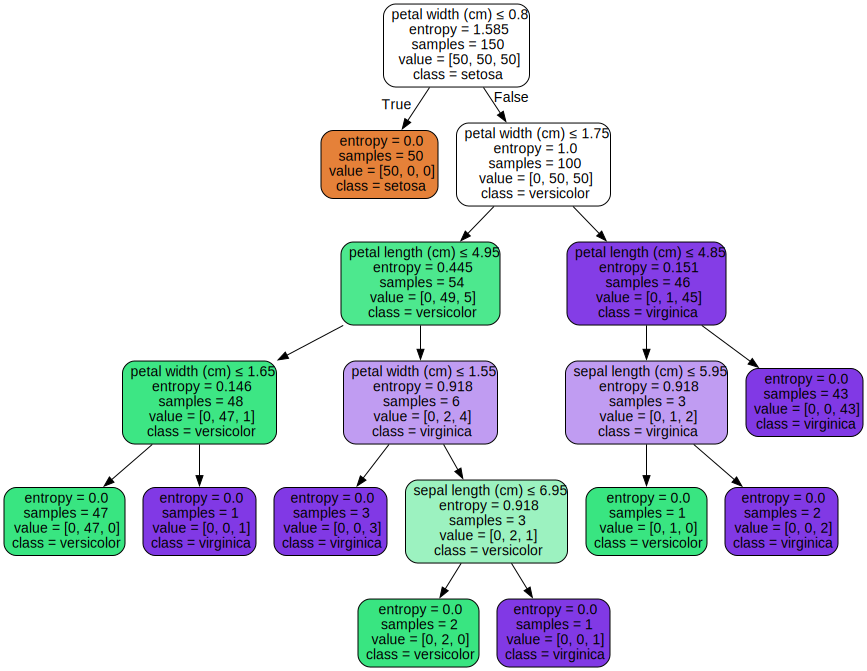

In [5]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render('iris')

dot_data = tree.export_graphviz(clf, 
                                out_file=None,
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True,
                                rounded=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph